# Exploratory Data Analysis – Credit Card Transactions

**Dataset:** creditcard.csv  
**Objective:**  
Initial inspection of anonymized bank transaction data to understand structure,
class imbalance, and feature distributions.


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


credit_df = pd.read_csv("../data/raw/creditcard.csv")


In [2]:
credit_df.info()

credit_df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

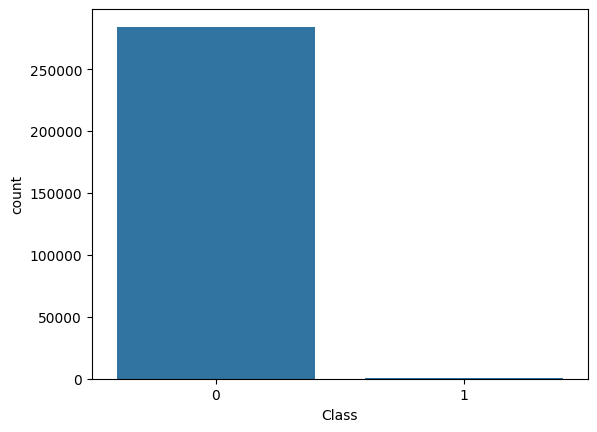

In [3]:
credit_df["Class"].value_counts(normalize=True) * 100

sns.countplot(x="Class", data=credit_df)
plt.show()

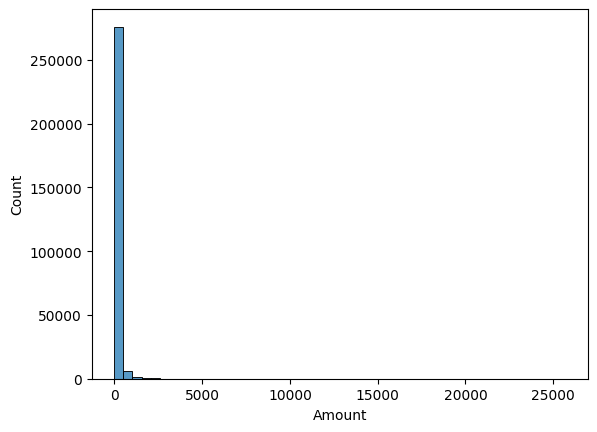

In [4]:
sns.histplot(credit_df["Amount"], bins=50)
plt.show()


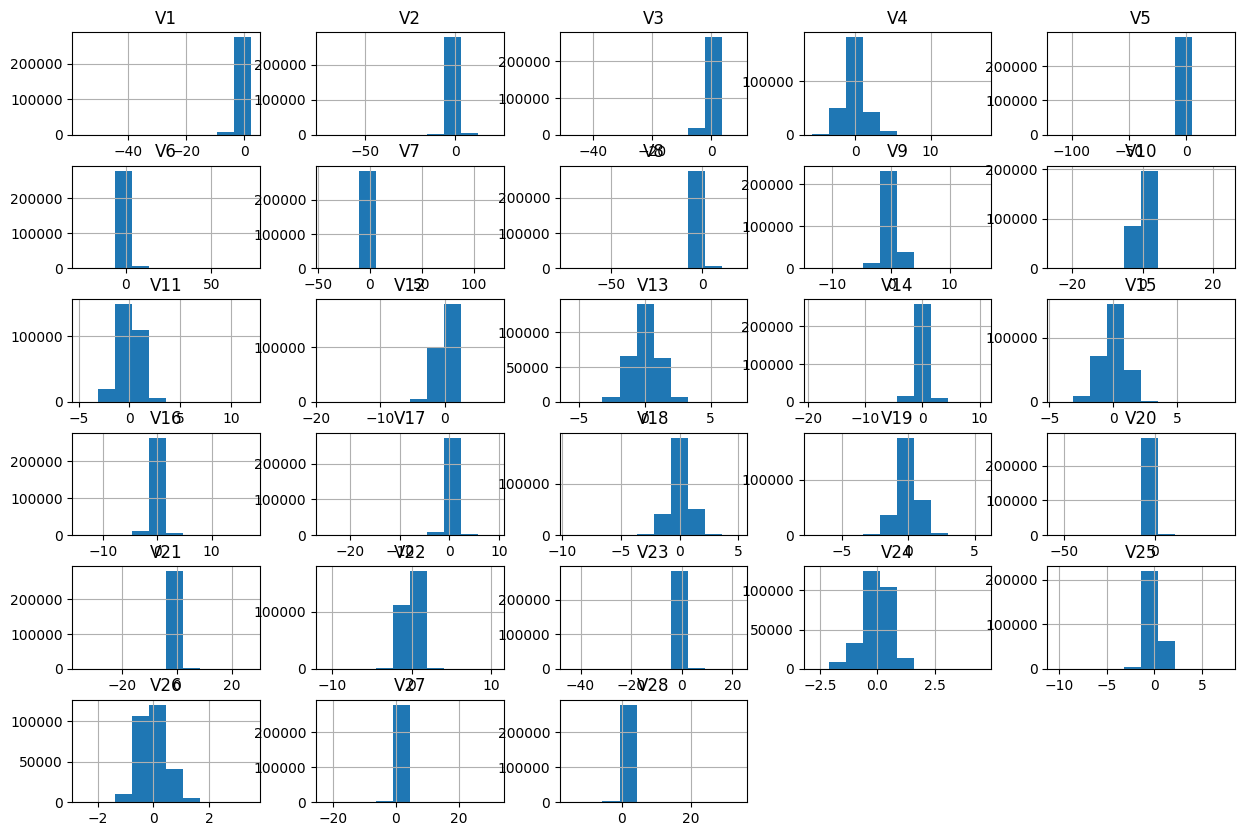

In [5]:
credit_df.iloc[:, 1:29].hist(figsize=(15, 10))
plt.show()


In [6]:
credit_df.to_csv("../data/processed/creditcard_processed.csv", index=False)


In [7]:
X_credit = credit_df.drop("Class", axis=1)
y_credit = credit_df["Class"]


In [11]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_credit, y_credit, test_size=0.2, stratify=y_credit, random_state=42
)


In [12]:
scaler_cc = StandardScaler()
Xc_train_scaled = scaler_cc.fit_transform(Xc_train)
Xc_test_scaled = scaler_cc.transform(Xc_test)


In [13]:
log_reg_cc = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_reg_cc.fit(Xc_train_scaled, yc_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


AUC-PR: 0.7189705771419241
F1 Score: 0.11435832274459974


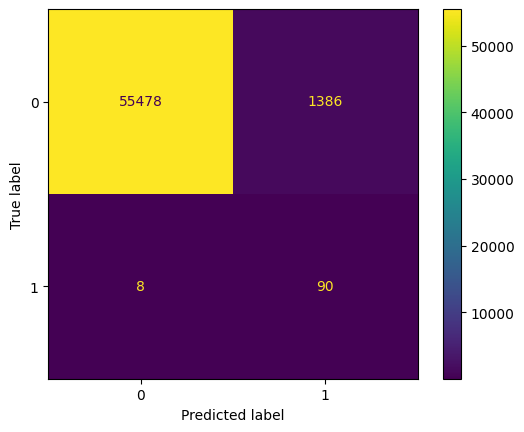

In [14]:
y_pred_lr_cc = log_reg_cc.predict(Xc_test_scaled)
y_proba_lr_cc = log_reg_cc.predict_proba(Xc_test_scaled)[:, 1]

print("AUC-PR:", average_precision_score(yc_test, y_proba_lr_cc))
print("F1 Score:", f1_score(yc_test, y_pred_lr_cc))

ConfusionMatrixDisplay.from_predictions(yc_test, y_pred_lr_cc)
plt.show()


In [16]:
rf_cc = RandomForestClassifier(n_estimators=300, max_depth=12,
                               class_weight="balanced", random_state=42, n_jobs=-1)
rf_cc.fit(Xc_train, yc_train)


,n_estimators,300
,criterion,'gini'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


AUC-PR: 0.83623216626489
F1 Score: 0.8290155440414507


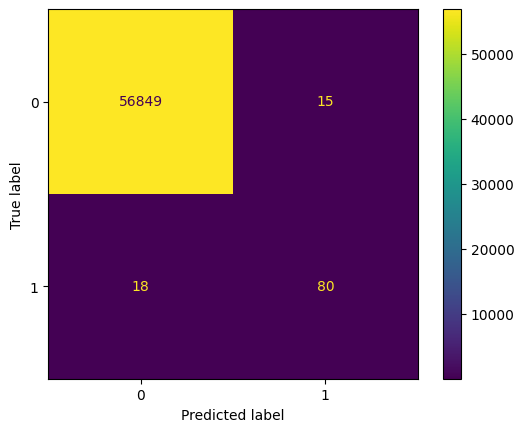

In [17]:
y_pred_rf_cc = rf_cc.predict(Xc_test)
y_proba_rf_cc = rf_cc.predict_proba(Xc_test)[:, 1]

print("AUC-PR:", average_precision_score(yc_test, y_proba_rf_cc))
print("F1 Score:", f1_score(yc_test, y_pred_rf_cc))

ConfusionMatrixDisplay.from_predictions(yc_test, y_pred_rf_cc)
plt.show()


In [19]:
from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"auc_pr": "average_precision", "f1": "f1"}


In [ ]:
cv_results_cc = cross_validate(rf_cc, X_credit, y_credit, cv=cv, scoring=scoring)
pd.DataFrame(cv_results_cc).agg(["mean", "std"])

Logistic Regression was used as a baseline for interpretability. 
Random Forest achieved higher AUC-PR and F1-scores across both datasets, 
capturing non-linear fraud patterns effectively. 

Considering performance and interpretability, Random Forest is selected as the final model, 
while Logistic Regression remains useful for auditing and explainability.